In [1]:
!pip install datasets

In [2]:
# HuginFace hub datasets
from datasets import list_datasets
datasets = list_datasets()
print(f"there are {len(datasets)} datasets currentely in the Hub")
print(f"the first ten are {datasets[:10]}")

/tmp/ipykernel_36/3987013904.py:3: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  datasets = list_datasets()


there are 204593 datasets currentely in the Hub
the first ten are ['amirveyseh/acronym_identification', 'ade-benchmark-corpus/ade_corpus_v2', 'UCLNLP/adversarial_qa', 'Yale-LILY/aeslc', 'nwu-ctext/afrikaans_ner_corpus', 'fancyzhx/ag_news', 'allenai/ai2_arc', 'google/air_dialogue', 'komari6/ajgt_twitter_ar', 'legacy-datasets/allegro_reviews']


###Note :
##### We see that each dataset is given a name

In [3]:
# inspect the metadata of emotion dataset in the Hub
metadata = list_datasets(with_details=True)[datasets.index("dair-ai/emotion")]

In [4]:
# show dataset description
l = metadata.description.split('\n')
d = l[l.index("\t\tDataset Summary")+3]
print("Description:", d)

Description: Emotion is a dataset of English Twitter messages with six basic emotions: anger, fear, joy, love, sadness, and surprise. For more detailed information please refer to the paper.


## Load the dataset :
 This looks like the dataset we’re after, so next we can load it with the load_dataset function from Datasets:

In [5]:
from datasets import load_dataset
# loading our emotions dataset
emotions = load_dataset("dair-ai/emotion")

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [7]:
# train
train_ds = emotions['train']
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [8]:
# show example
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [9]:
train_ds.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

In [10]:
# We can also access several rows with a slice
train_ds[:5]

{'text': ['i didnt feel humiliated',
  'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
  'im grabbing a minute to post i feel greedy wrong',
  'i am ever feeling nostalgic about the fireplace i will know that it is still on the property',
  'i am feeling grouchy'],
 'label': [0, 0, 3, 2, 3]}

###  From Datasets to DataFrames
 it is often convenient to convert a Dataset object to a Pandas DataFrame so we can access high level APIs for data visualization.

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
emotions.set_format(type="pandas")
df = emotions['train'][:]

In [12]:
df

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3
...,...,...
15995,i just had a very brief time in the beanbag an...,0
15996,i am now turning and i feel pathetic that i am...,0
15997,i feel strong and good overall,1
15998,i feel like this was such a rude comment and i...,3


In [13]:
# turn labels from integers to strings
def label_int2str(row , split) :
  return emotions[split].features['label'].int2str(row)
df["label_name"] = df['label'].apply(label_int2str , split='train')

In [14]:
df

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
...,...,...,...
15995,i just had a very brief time in the beanbag an...,0,sadness
15996,i am now turning and i feel pathetic that i am...,0,sadness
15997,i feel strong and good overall,1,joy
15998,i feel like this was such a rude comment and i...,3,anger


###  Look at the Class Distribution

Text(0.5, 1.0, 'Category Counts')

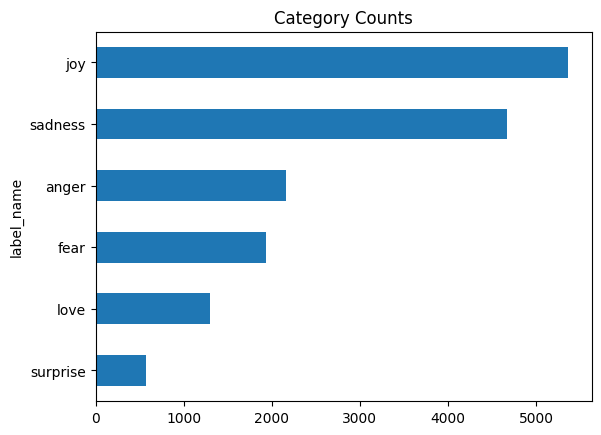

In [15]:
df['label_name'].value_counts(ascending=True).plot.barh()
plt.title("Category Counts")

###  How Long Are Our Tweets?

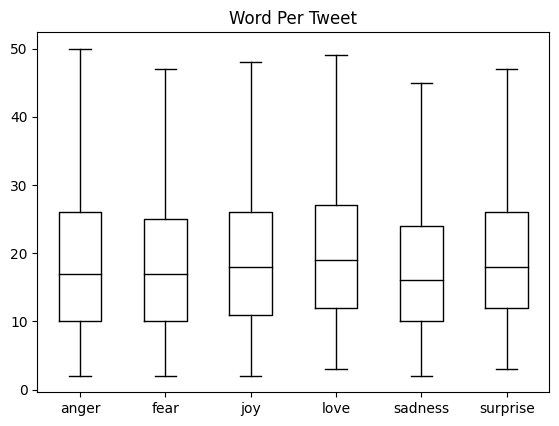

In [16]:
df["Word Per Tweet"] = df['text'].str.split().apply(len)
df.boxplot("Word Per Tweet" , by='label_name'  ,grid=False, showfliers=False,color='black' )
plt.suptitle("")
plt.xlabel("");

### From Text to Tokens
 To build our emotion detector we’ll use a BERT variant called DistilBERT, which is a downscaled version of the original BERT model. The main advantage of this model is that it achieves comparable performance to BERT while being significantly smaller and more efficient.

In [17]:
from transformers import AutoTokenizer
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [18]:
tokenizer

DistilBertTokenizerFast(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}

In [19]:
# example of encoding
encode_str = tokenizer.encode("this is a complicatedtest")
encode_str

[101, 2023, 2003, 1037, 8552, 22199, 102]

In [20]:
for token in encode_str :
  print(token , tokenizer.decode([token]))

101 [CLS]
2023 this
2003 is
1037 a
8552 complicated
22199 ##test
102 [SEP]


### Training a Text Classifier
#### 1-Transformers as Feature Extractors
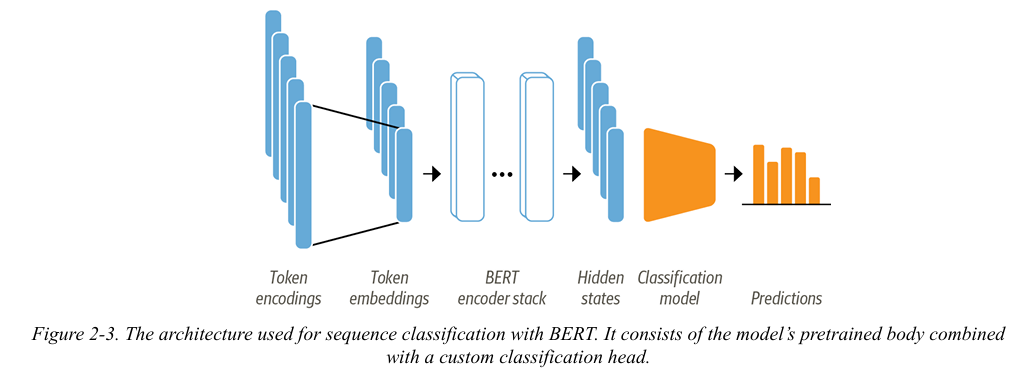

In [21]:
from transformers import AutoModel
import torch
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
model = AutoModel.from_pretrained(model_name).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [22]:
# Extracting the Last Hidden States
text = "this is test"
text_tensor = tokenizer.encode(text , return_tensors="pt").to(device) # return_tensors="pt" ensures that the encodings are in the form of PyTorch tensors

In [23]:
text_tensor

tensor([[ 101, 2023, 2003, 3231,  102]], device='cuda:0')

In [24]:
model

DistilBertModel(
  (embeddings): Embeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer): Transformer(
    (layer): ModuleList(
      (0-5): 6 x TransformerBlock(
        (attention): MultiHeadSelfAttention(
          (dropout): Dropout(p=0.1, inplace=False)
          (q_lin): Linear(in_features=768, out_features=768, bias=True)
          (k_lin): Linear(in_features=768, out_features=768, bias=True)
          (v_lin): Linear(in_features=768, out_features=768, bias=True)
          (out_lin): Linear(in_features=768, out_features=768, bias=True)
        )
        (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (ffn): FFN(
          (dropout): Dropout(p=0.1, inplace=False)
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Li

In [25]:
# get the last hidden state shape
output = model(text_tensor)
output.last_hidden_state.shape

torch.Size([1, 5, 768])

### Tokenizing the Whole Dataset

In [26]:
def tokenize(batch) :
  return tokenizer(batch['text'] , truncation=True , padding=True)

In [27]:
# Previously, we set the output format of the dataset to "pandas" so that the accessed data is returned as a DataFrame. We don’t need this output format anymore so we can now reset it
emotions.reset_format()

In [28]:
tokenize(emotions["train"][:3])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102], [101, 10047, 9775, 1037, 3371, 2000, 2695, 1045, 2514, 20505, 3308, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]}

In [29]:
#  apply our tokenize function to the whole emotions corpus,
emotions_encoded = emotions.map(tokenize  , batched=True , batch_size=None)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [30]:
emotions_encoded["train"].features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [31]:
def forward_pass(batch) :
  input_ids = torch.tensor(batch['input_ids']).to(device)
  attention_mask = torch.tensor(batch['attention_mask']).to(device)
  with torch.no_grad() :
    last_hidden_state = model(input_ids , attention_mask).last_hidden_state
    last_hidden_state = last_hidden_state.cpu().numpy()
  # Use average of unmasked hidden states for classification
  lhs_shape = last_hidden_state.shape
  boolean_mask =  ~np.array(batch['attention_mask']).astype(bool)
  boolean_mask = np.repeat(boolean_mask , lhs_shape[-1] , axis=-1)
  boolean_mask = boolean_mask.reshape(lhs_shape)
  masked_mean = np.ma.array(last_hidden_state, mask=boolean_mask).mean(axis=1)
  batch["hidden_state"] = masked_mean.data
  return batch
emotions_encoded = emotions_encoded.map(forward_pass, batched=True,
batch_size=16)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [32]:
len(emotions_encoded['train']['hidden_state'])

16000

In [33]:
X_train = np.array(emotions_encoded["train"]["hidden_state"])
X_valid = np.array(emotions_encoded["validation"]["hidden_state"])
y_train = np.array(emotions_encoded["train"]["label"])
y_valid = np.array(emotions_encoded["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Dimensionality Reduction with UMAP

In [34]:
!pip install umap-learn

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [35]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
X_scaled = MinMaxScaler().fit_transform(X_train)
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb

,X,Y,label
0,6.086968,4.684993,0
1,1.126050,4.354994,0
2,5.654973,1.935343,3
3,2.396190,2.766830,2
4,0.611251,6.723998,3
...,...,...,...
15995,3.291368,4.746795,0
15996,1.690305,4.140231,0
15997,-1.354527,4.118642,1
15998,5.962439,3.484260,3


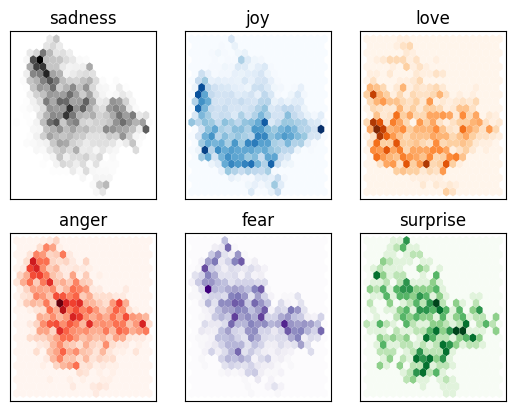

In [54]:
fig , axes = plt.subplots(2,3)
axes = axes.flatten()
labels = emotions['train'].features['label'].names
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Purples", "Greens"] 
for i , (label , cmap) in enumerate(zip(labels, cmaps)) :
    df_emb_sub = df_emb[df_emb["label"] == i] 
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, 
    gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

### Training a Simple Classifier

In [56]:
from sklearn.linear_model import LogisticRegression 
lr_clf = LogisticRegression(n_jobs=-1, penalty="none")
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.6495

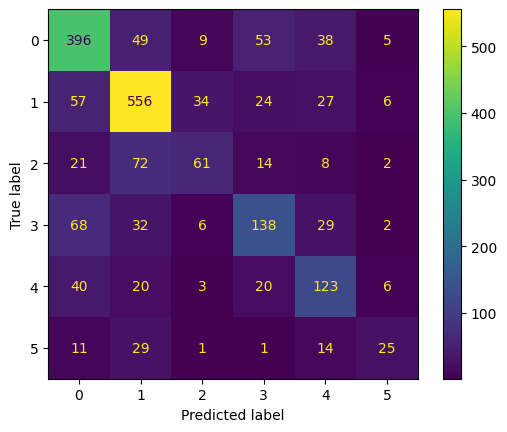

In [61]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
y_preds = lr_clf.predict(X_valid)
cm = confusion_matrix(y_valid, y_preds) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [62]:
from sklearn.metrics import classification_report 
print(classification_report(y_valid, y_preds, target_names=labels))

              precision    recall  f1-score   support

     sadness       0.67      0.72      0.69       550
         joy       0.73      0.79      0.76       704
        love       0.54      0.34      0.42       178
       anger       0.55      0.50      0.53       275
        fear       0.51      0.58      0.55       212
    surprise       0.54      0.31      0.39        81

    accuracy                           0.65      2000
   macro avg       0.59      0.54      0.56      2000
weighted avg       0.64      0.65      0.64      2000



### Second method :Fine-tuning Transformers

In [64]:
from transformers import AutoModelForSequenceClassification 
num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_name , num_labels=num_labels).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
# turn to tensor 
emotions_encoded = emotions.map(tokenize  , batched=True , batch_size=None)
emotions_encoded.set_format('torch' , columns=["input_ids", "attention_mask", "label"])

In [72]:
emotions_encoded['train'][0]

{'label': tensor(0),
 'input_ids': tensor([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0

### Define the Performance Metrics

In [81]:
from sklearn.metrics import accuracy_score , f1_score
def compute_metrics(pred) : 
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted") 
    acc = accuracy_score(labels, preds) 
    return {"accuracy": acc, "f1": f1}

### Training the Model

In [78]:
from transformers import Trainer , TrainingArguments 
batch_size = 64
logging_steps = len(emotions_encoded["train"]) // batch_size
training_args = TrainingArguments(
    output_dir="results",
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    weight_decay=0.01,
    evaluation_strategy="epoch",  # Evaluate and save at the end of each epoch
    save_strategy="epoch",         # Save the model at the end of each epoch
    disable_tqdm=False,
    logging_steps=logging_steps,
)

In [82]:
# train the model 
trainer = Trainer(model=model, args=training_args, 
                    compute_metrics=compute_metrics, 
                    train_dataset=emotions_encoded["train"], 
                    eval_dataset=emotions_encoded["validation"]
                 )
trainer.train();

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.832800,0.315652,0.909500,0.909294
2,0.253700,0.215583,0.923000,0.923032


In [83]:
results = trainer.evaluate()

In [84]:
results

{'eval_loss': 0.21558289229869843,
 'eval_accuracy': 0.923,
 'eval_f1': 0.9230321908498731,
 'eval_runtime': 2.2248,
 'eval_samples_per_second': 898.951,
 'eval_steps_per_second': 14.383,
 'epoch': 2.0}

In [86]:
# dipslay cm matrix 
preds_output = trainer.predict(emotions_encoded["validation"])
preds_output.metrics

{'test_loss': 0.21558289229869843,
 'test_accuracy': 0.923,
 'test_f1': 0.9230321908498731,
 'test_runtime': 2.2228,
 'test_samples_per_second': 899.762,
 'test_steps_per_second': 14.396}

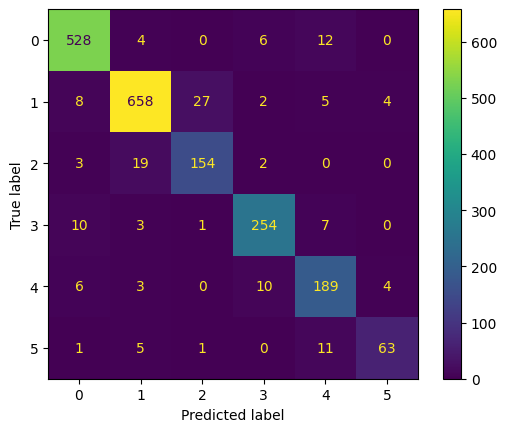

In [94]:
y_preds = np.argmax(preds_output.predictions , axis=1)
cm = confusion_matrix(preds_output.label_ids , y_preds)
display = ConfusionMatrixDisplay(cm)
display.plot()

In [95]:
 print(classification_report(preds_output.label_ids, y_preds, target_names=labels))

              precision    recall  f1-score   support

     sadness       0.95      0.96      0.95       550
         joy       0.95      0.93      0.94       704
        love       0.84      0.87      0.85       178
       anger       0.93      0.92      0.93       275
        fear       0.84      0.89      0.87       212
    surprise       0.89      0.78      0.83        81

    accuracy                           0.92      2000
   macro avg       0.90      0.89      0.90      2000
weighted avg       0.92      0.92      0.92      2000



###  Making Predictions

In [96]:
custom_tweet = "i saw a movie today and it was really good."
input_tensor = tokenizer.encode(custom_tweet, return_tensors="pt").to(device)
logits = model(input_tensor).logits

In [97]:
logits 

tensor([[-0.2395,  3.7537, -0.4901, -1.0459, -1.4463, -0.7976]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [98]:
softmax = torch.nn.Softmax(dim=1)
probs = softmax(logits)[0]
probs = probs.cpu().detach().numpy()

In [99]:
probs

array([0.0174437 , 0.94598776, 0.01357783, 0.0077886 , 0.00521845,
       0.00998368], dtype=float32)

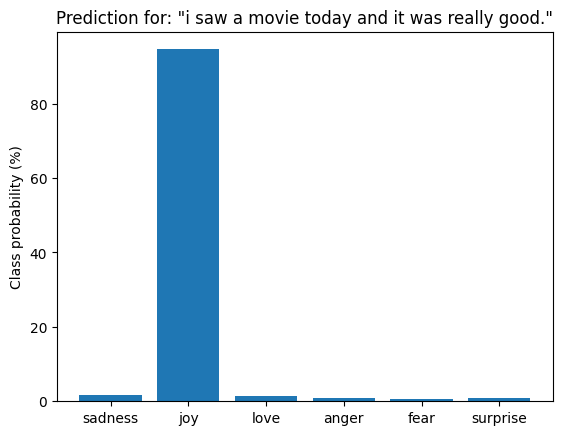

In [100]:
# plot proba distro
plt.bar(labels, 100 * probs, color='C0')
plt.title(f'Prediction for: "{custom_tweet}"')
plt.ylabel("Class probability (%)");

### Error Analysis

In [105]:
from torch.nn.functional import cross_entropy 
def forward_pass_with_label(batch): 
    input_ids = torch.tensor(batch["input_ids"], device=device) 
    attention_mask = torch.tensor(batch["attention_mask"], device=device) 
    labels = torch.tensor(batch["label"], device=device) 
    with torch.no_grad(): 
        output = model(input_ids, attention_mask) 
        pred_label = torch.argmax(output.logits, axis=-1) 
        loss = cross_entropy(output.logits, labels, reduction="none") 
    batch["predicted_label"] = pred_label.cpu().numpy() 
    batch["loss"] = loss.cpu().numpy() 
    return batch

In [106]:
emotions_encoded.reset_format()
emotions_encoded["validation"] = emotions_encoded["validation"].map( 
forward_pass_with_label, batched=True, batch_size=16)    

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [107]:
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["label"] = df_test["label"].apply(label_int2str, split="test")
df_test["predicted_label"] = (df_test["predicted_label"] .apply(label_int2str, split="test"))

In [108]:
df_test

,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.024224
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.024683
2,i feel like a faithful servant,love,love,0.462461
3,i am just feeling cranky and blue,anger,anger,0.035835
4,i can have for a treat or if i am feeling festive,joy,joy,0.022388
...,...,...,...,...
1995,im having ssa examination tomorrow in the morn...,sadness,sadness,0.040394
1996,i constantly worry about their fight against n...,joy,joy,0.022588
1997,i feel its important to share this info for th...,joy,joy,0.030136
1998,i truly feel that if you are passionate enough...,joy,love,0.904762
